In [5]:
import pandas as pd
import numpy as np
import datetime
import platform
import re
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from IPython.display import display, Image

## 0. Start Chromedriver
- **`CHROME_VERSION`**: go to your chrome settings and check your version of chrome. If your version does not match the version shown below, download the correct version of the Chromedriver from [here](https://chromedriver.chromium.org/downloads) and append the version number to the end of its name. e.g. if you have Chrome version 80, you should rename `chromedriver.exe` to `chromedriver80.exe`
  - **`Options()`**: adding `headless` and `window-size` arguments allows us to use Chromedriver without a GUI.

In [6]:
CHROME_VERSION='79'  # change this to match Chrome version on host machine

options = Options()
options.add_argument('headless')
options.add_argument('window-size=1200x600')

global driver
if platform.system() == 'Windows':
    driver = webdriver.Chrome(f'./chromedriver/chromedriver{CHROME_VERSION}.exe', options=options)
else:
    driver = webdriver.Chrome(f'./chromedriver/chromedriver{CHROME_VERSION}', options=options)

---
## 1. Load upcoming Super Rugby match odds

In [7]:
driver.get( "https://www.oddsportal.com/rugby-union/world/super-rugby/")
driver.implicitly_wait(5)  # give page time to load all content

We can take a peek at what the Chromedriver sees using the `get_screenshot_as_png()` method on the driver object.

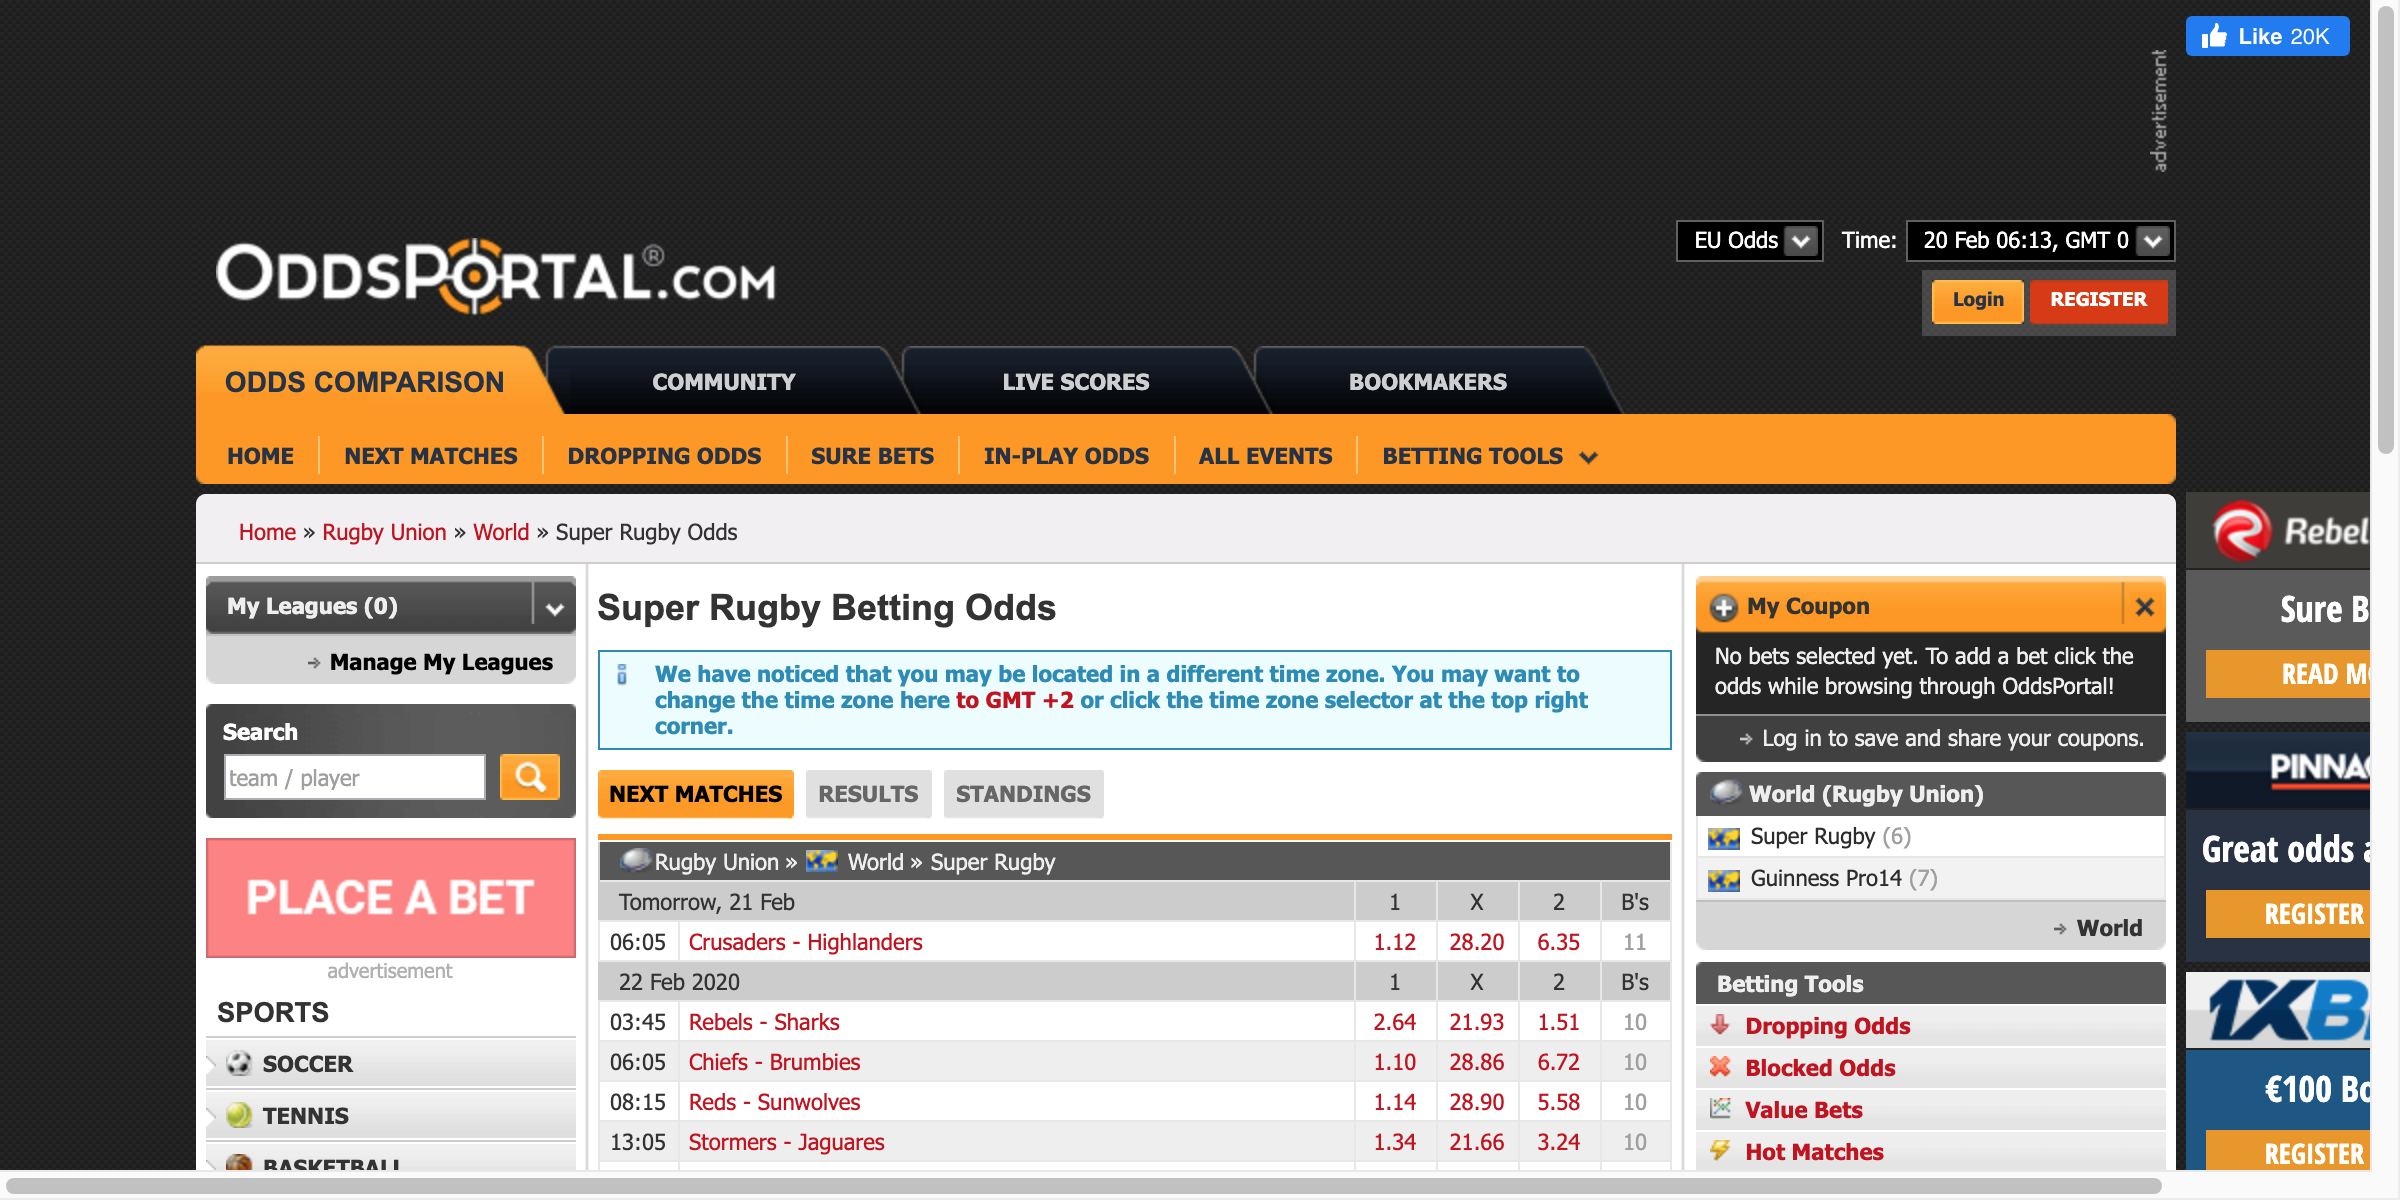

In [13]:
display(
    Image(
        driver.get_screenshot_as_png(),
        width=800,
        height=500
    )
)

In [14]:
table = driver.find_element_by_xpath('//*[@id="tournamentTable"]')

In [15]:
table.find_elements_by_xpath('//*[@id="tournamentTable"]/tbody/tr[7]')

[<selenium.webdriver.remote.webelement.WebElement (session="ba17eff5c72481681ec88bf7818deb1e", element="96ec56ec-d178-4c77-af6b-46669953d7bd")>]

In [16]:
table.text

"Rugby Union\n»\n World\n»\nSuper Rugby\nTomorrow, 21 Feb 1 X 2 B's\n06:05 Crusaders - Highlanders\n1.12\n28.20\n6.35\n11\n22 Feb 2020 1 X 2 B's\n03:45 Rebels - Sharks\n2.64\n21.93\n1.51\n10\n06:05 Chiefs - Brumbies\n1.10\n28.86\n6.72\n10\n08:15 Reds - Sunwolves\n1.14\n28.90\n5.58\n10\n13:05 Stormers - Jaguares\n1.34\n21.66\n3.24\n10\n15:15 Bulls - Blues\n2.08\n20.98\n1.77\n10"

In [17]:
table_rows = table.text.split('\n')
table_rows[:25]

['Rugby Union',
 '»',
 ' World',
 '»',
 'Super Rugby',
 "Tomorrow, 21 Feb 1 X 2 B's",
 '06:05 Crusaders - Highlanders',
 '1.12',
 '28.20',
 '6.35',
 '11',
 "22 Feb 2020 1 X 2 B's",
 '03:45 Rebels - Sharks',
 '2.64',
 '21.93',
 '1.51',
 '10',
 '06:05 Chiefs - Brumbies',
 '1.10',
 '28.86',
 '6.72',
 '10',
 '08:15 Reds - Sunwolves',
 '1.14',
 '28.90']

In [18]:
# remove table header (first 5 lines)
table_rows = table_rows[5:]

In [19]:
# split list up by dates
date_idx = []
idx = 0
for row in table_rows:
    if "1 X 2 B's" in row:
        print(row)
        date_idx.append(idx)
    idx += 1

Tomorrow, 21 Feb 1 X 2 B's
22 Feb 2020 1 X 2 B's


In [20]:
date_idx

[0, 6]

In [21]:
# schema of dataframe
df = {
    'Date': [],
    'Home Team': [],
    'Away Team': [],
    'Home Score': [],
    'Away Score': [],
    'Play-off Game?': [],
    'Home Odds': [],
    'Draw Odds': [],
    'Away Odds': [],
    'Bookmakers Surveyed': []
}

# for each separate date
for i in range(len(date_idx)):
    
    # extract date
    date = table_rows[date_idx[i]]
    date = date.replace(" 1 X 2 B's", '')
    
    # remove unnecessary text
    if 'Tomorrow' in date or 'Today' in date:
        date = date[date.find(',')+2: ] + ' ' + str(datetime.datetime.now().year)
        
    date = date.replace(' ', '-')
    
    first_match = date_idx[i]+1
    
    fixtures = []
    
    if i < len(date_idx)-1:
        last_match = date_idx[i+1]
        fixtures = table_rows[first_match:last_match]
        
    else:
        fixtures = table_rows[first_match:]
        
    fixtures = np.array(fixtures).reshape(-1, 5)
    date_col = np.repeat([date], fixtures.shape[0])
    fixtures = np.hstack((date_col.reshape(-1, 1), fixtures))
    
    # add each row to dictionary
    for f in fixtures:
        df['Date'].append(f[0])
        df['Home Team'].append(f[1])
        df['Away Team'].append(f[1])
        df['Home Score'].append(0)
        df['Away Score'].append(0)
        df['Play-off Game?'].append('')
        df['Home Odds'].append(f[2])
        df['Draw Odds'].append(f[3])
        df['Away Odds'].append(f[4])
        df['Bookmakers Surveyed'].append(f[-1])

# convert dictionary to dataframe
df = pd.DataFrame(df)
df.head(7)

,Date,Home Team,Away Team,Home Score,Away Score,Play-off Game?,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,21-Feb-2020,06:05 Crusaders - Highlanders,06:05 Crusaders - Highlanders,0,0,,1.12,28.20,6.35,11
1,22-Feb-2020,03:45 Rebels - Sharks,03:45 Rebels - Sharks,0,0,,2.64,21.93,1.51,10
2,22-Feb-2020,06:05 Chiefs - Brumbies,06:05 Chiefs - Brumbies,0,0,,1.10,28.86,6.72,10
3,22-Feb-2020,08:15 Reds - Sunwolves,08:15 Reds - Sunwolves,0,0,,1.14,28.90,5.58,10
4,22-Feb-2020,13:05 Stormers - Jaguares,13:05 Stormers - Jaguares,0,0,,1.34,21.66,3.24,10
5,22-Feb-2020,15:15 Bulls - Blues,15:15 Bulls - Blues,0,0,,2.08,20.98,1.77,10


In [22]:
def get_home(s):
    '''find the text between the kick-off time and the dash'''
    return re.search(r'[0-2][0-9]:[0-6][0-9](.*?)-', s).group(1).strip()

def get_away(s):
    '''find the last word of text'''
    return s.split()[-1]

print(get_home('06:05 Blues - Chiefs'))
print(get_away('06:05 Blues - Chiefs'))

Blues
Chiefs


In [23]:
df['Home Team'] = df['Home Team'].apply(get_home)
df['Away Team'] = df['Away Team'].apply(get_away)

df.head(7)

,Date,Home Team,Away Team,Home Score,Away Score,Play-off Game?,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,21-Feb-2020,Crusaders,Highlanders,0,0,,1.12,28.20,6.35,11
1,22-Feb-2020,Rebels,Sharks,0,0,,2.64,21.93,1.51,10
2,22-Feb-2020,Chiefs,Brumbies,0,0,,1.10,28.86,6.72,10
3,22-Feb-2020,Reds,Sunwolves,0,0,,1.14,28.90,5.58,10
4,22-Feb-2020,Stormers,Jaguares,0,0,,1.34,21.66,3.24,10
5,22-Feb-2020,Bulls,Blues,0,0,,2.08,20.98,1.77,10


## Fetch Existing Dataset

In [24]:
# read in existing data
existing_dataset = pd.read_csv('./data/super_rugby_oddsportal.csv')

# replace NaNs with empty strings
existing_dataset.fillna('', inplace=True)

existing_dataset.head()

,Date,Home Team,Away Team,Home Score,Away Score,Play-off Game?,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,14-Feb-20,Blues,Crusaders,0,0,,3.47,24.74,1.31,11
1,14-Feb-20,Rebels,Waratahs,0,0,,1.61,20.81,2.35,11
2,15-Feb-20,Sunwolves,Chiefs,0,0,,9.49,40.78,1.05,11
3,15-Feb-20,Hurricanes,Sharks,0,0,,1.31,24.35,3.41,11
4,15-Feb-20,Brumbies,Highlanders,0,0,,1.44,22.14,2.78,11


## Add Scraped Odds to Existing Dataset

In [25]:
# add new odds to existing
combined_df = pd.concat([df, existing_dataset], ignore_index=True)

In [28]:
combined_df.head(10)

,Date,Home Team,Away Team,Home Score,Away Score,Play-off Game?,Home Odds,Draw Odds,Away Odds,Bookmakers Surveyed
0,21-Feb-2020,Crusaders,Highlanders,0,0,,1.12,28.20,6.35,11
1,22-Feb-2020,Rebels,Sharks,0,0,,2.64,21.93,1.51,10
2,22-Feb-2020,Chiefs,Brumbies,0,0,,1.10,28.86,6.72,10
3,22-Feb-2020,Reds,Sunwolves,0,0,,1.14,28.90,5.58,10
4,22-Feb-2020,Stormers,Jaguares,0,0,,1.34,21.66,3.24,10
5,22-Feb-2020,Bulls,Blues,0,0,,2.08,20.98,1.77,10
6,14-Feb-20,Blues,Crusaders,0,0,,3.47,24.74,1.31,11
7,14-Feb-20,Rebels,Waratahs,0,0,,1.61,20.81,2.35,11
8,15-Feb-20,Sunwolves,Chiefs,0,0,,9.49,40.78,1.05,11
9,15-Feb-20,Hurricanes,Sharks,0,0,,1.31,24.35,3.41,11


In [27]:
combined_df.shape

(1372, 10)

## Save Updated Dataset to CSV

In [29]:
combined_df.to_csv('./data/super_rugby_oddsportal.csv', index=False)